In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Font modification
#plt.rcParams['font.sans-serif'] = "Times New Roman"
#plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 18


In [3]:
# Use with caution
if True:
    import warnings
    warnings.filterwarnings("ignore")

# Data loading and assembly

In [4]:
spectra = pd.read_csv('../data/cleanedset.csv')
columns = ['target', 'sampleID'] 
columns.extend([str(x) for x in range(950, 1530+1,2)])
spectra = spectra[columns]
print(spectra.shape)
spectra.head()

(591, 293)


,target,sampleID,950,952,954,956,958,960,962,964,...,1512,1514,1516,1518,1520,1522,1524,1526,1528,1530
0,94.333333,0.0,36.723839,35.745964,34.811623,33.955212,33.197552,32.570518,32.147972,31.807793,...,0.791820,0.831189,0.883438,0.940272,0.993729,1.046867,1.098642,1.152454,1.215338,1.271571
1,94.333333,0.0,36.369366,35.383987,34.443897,33.584080,32.823158,32.192280,31.770844,31.431589,...,0.685869,0.728103,0.785778,0.845810,0.902551,0.961095,1.017545,1.073209,1.138063,1.196826
2,94.333333,0.0,35.385422,34.405182,33.466976,32.614578,31.862633,31.242191,30.828016,30.496775,...,0.618997,0.659589,0.712821,0.769303,0.822148,0.875681,0.929040,0.979519,1.040625,1.100850
3,94.333333,0.0,35.121685,34.145687,33.217796,32.374218,31.630789,31.019081,30.611959,30.286642,...,0.751016,0.796110,0.852175,0.909087,0.965727,1.024710,1.080235,1.133445,1.197904,1.262516
4,76.333333,1.0,36.185947,35.209904,34.280155,33.430157,32.679989,32.062084,31.647160,31.312046,...,1.001077,1.051815,1.112780,1.175900,1.240040,1.304035,1.365576,1.426388,1.495515,1.561842


# Regression

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union

## Folds definition

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=47)

## Split definition

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(spectra, spectra['target'], test_size=0.33, random_state=53)

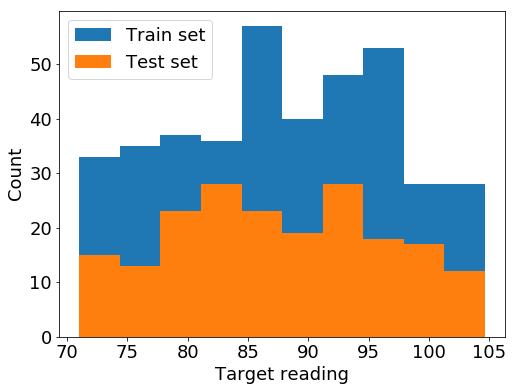

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(y_train, label='Train set')
plt.hist(y_test, label='Test set')
plt.legend()
plt.xlabel('Target reading')
plt.ylabel('Count')
plt.savefig('train vs test.png', bbox_inches = 'tight')
plt.show()

## Savgol filter

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

In [10]:
from scipy.signal import savgol_filter

class Savgol(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self, window_length=5, polyorder=2, deriv=0, wavemin=950, wavemax=1530):# 
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
        self.wavemin = wavemin
        self.wavemax = wavemax
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        colnames = [str(x) for x in range(self.wavemin, self.wavemax+1,2)]
        df = X[colnames].copy(deep=True)
        toreturn = df.apply(savgol_filter, args=(self.window_length, self.polyorder, self.deriv,1. , 0, 'nearest'), axis=1, raw=True, result_type='broadcast')
        return toreturn

params={'window_length':27, 'polyorder':2, 'deriv':2}
savgol = Savgol(**params)
Xtr = savgol.fit_transform(X_train)
Xtr.shape

(395, 291)

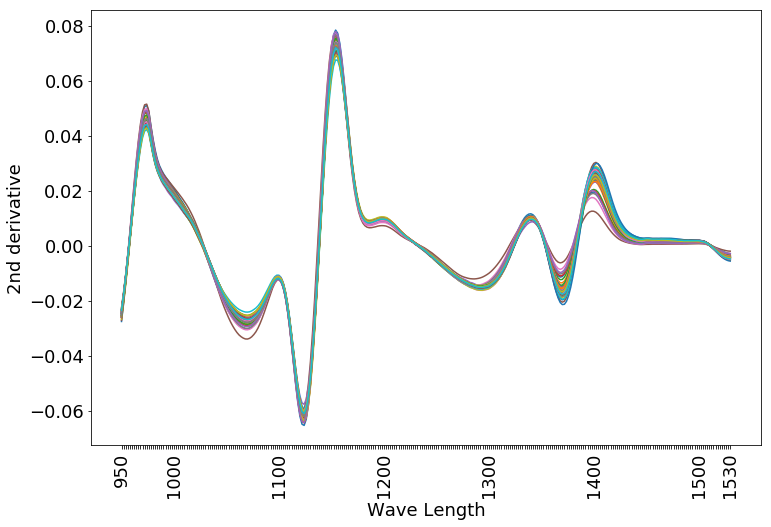

In [11]:
df = savgol.transform(X_train)
df.head(50).T.plot(legend=None, figsize=(12,8))
#plt.title('Spectras - 1rst derivative')
plt.xlabel('Wave Length') #,fontname="Times New Roman", fontsize=18
plt.ylabel('2nd derivative')
#plt.yticks(fontname="Times New Roman", fontsize=18)
#plt.xticks(fontname="Times New Roman", fontsize=18)

plt.xticks(np.arange(len(df.columns)), [v if (int(v) % 100 == 0) or k==0 or k==len(df.columns)-1 else '' for (k,v) in enumerate(df.columns)], rotation=90)
plt.savefig('genera - raw Spectras - 2nd derivative.png')
plt.show()

## Log(1/(p+n))

In [12]:
class Log1overN(BaseEstimator, TransformerMixin):
    def __init__(self, n=1):# 
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy(deep=True)
        toreturn = df.apply(lambda x:np.log(1/(x+self.n)), axis=0)
        return toreturn

log1over = Log1overN(n=3)
log1over.fit_transform(X_train).shape

(395, 293)

## SNV

In [13]:
class Snv(BaseEstimator, TransformerMixin):
    def __init__(self,):# 
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data_snv = np.zeros_like(X.values)
        for i in range(X.shape[0]):
            # Apply correction
            data_snv[i,:] = (X.values[i,:] - np.mean(X.values[i,:])) / np.std(X.values[i,:])
        return pd.DataFrame(data_snv, columns=X.columns, index=X.index)

snv = Snv()
snv.fit_transform(X_train).shape

(395, 293)

## Blocs creation

In [14]:
params={'window_length':13, 'polyorder':3, 'deriv':2}
savgol = Savgol(**params)

In [15]:
snv = Snv()

In [16]:
log1over = Log1overN(n=3)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [18]:
from sklearn.decomposition import PCA
pca = PCA()

# Tree construction

In [19]:
lrpipelist1 = [#
               ('snv', snv),
               ('savgol', savgol),
               ('log1over', log1over),
               ('scaler', scaler),
               ('pca', pca),
                ] #
pipe1 = Pipeline(lrpipelist1)
#Xtrans = pipe1.fit_transform(spectra)#.shape

In [20]:
pipe1.fit_transform(X_train).shape

(395, 291)

In [21]:
from sklearn.linear_model import ElasticNet
elnet = ElasticNet(random_state=0, max_iter=10000)

In [22]:
listpipereg = [('pipe1', pipe1), ('elnet', elnet)] #
pipereg = Pipeline(listpipereg)

In [23]:
pipereg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pipe1', Pipeline(memory=None,
     steps=[('snv', Snv()), ('savgol', Savgol(deriv=2, polyorder=3, wavemax=1530, wavemin=950, window_length=13)), ('log1over', Log1overN(n=3)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', ...e=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False))])

## Component Selection - Elastic net

In [24]:
rmsecv = []
components = [2,5,]
components.extend(np.arange(10,50+1,5))
alpha_opt = []
l1_ratio_opt = []

for component in components:
    pipe1.set_params(pca__n_components=component)
    Xtrans = pipe1.fit_transform(X_train)
    
    elnet = ElasticNet(random_state=0)
    
    alpha_range = np.logspace(-3, 0, 11)
    l1_ratio_range = np.linspace(0.0001, 1, 11)
    param_grid = dict(alpha=alpha_range, l1_ratio=l1_ratio_range)
    
    gridpca = GridSearchCV(elnet, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error')
    gridpca.fit(Xtrans, y_train)
    
    alpha_opt.append(gridpca.best_params_['alpha'])
    l1_ratio_opt.append(gridpca.best_params_['l1_ratio'])
    
    elnet = ElasticNet(random_state=0, **gridpca.best_params_)
    
    
    #preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf, n_jobs=-2)
    preds = gridpca.predict(pipe1.transform(X_test))
    score = mean_squared_error(y_test , preds)
    
    rmsecv.append(score)

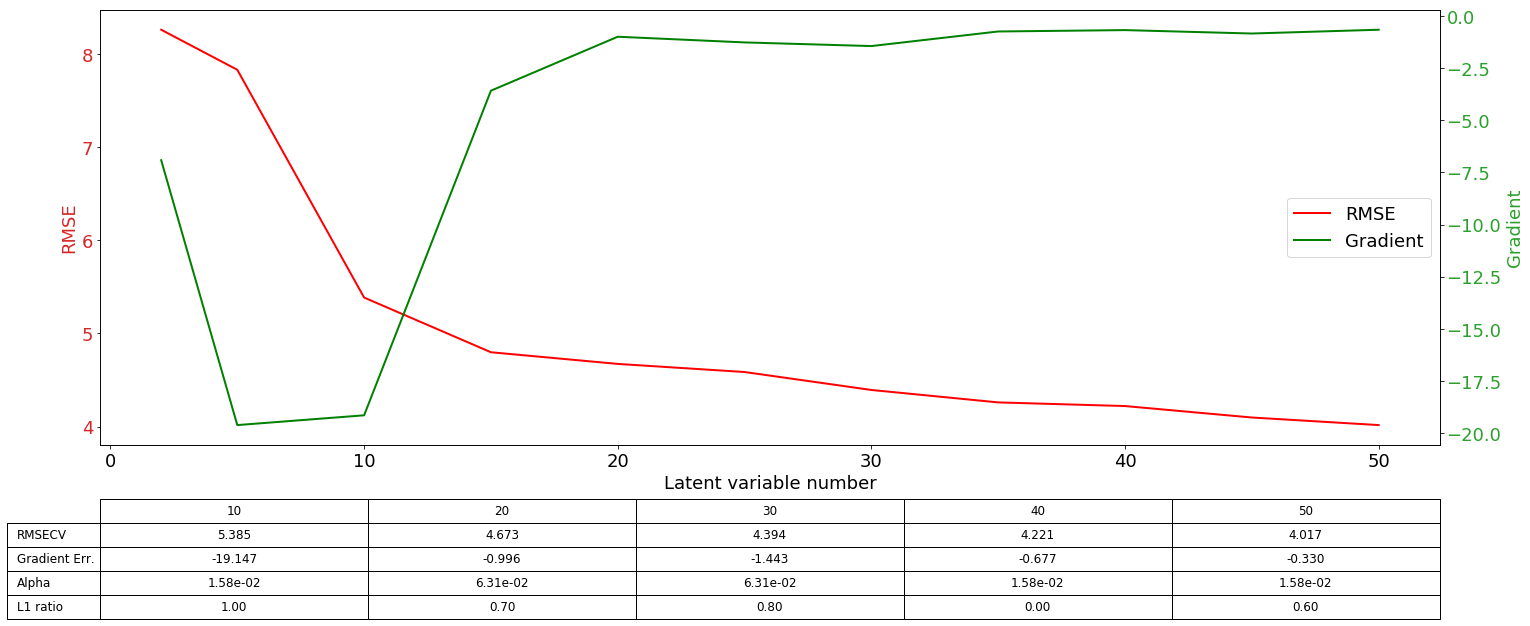

In [25]:
fig, ax1 = plt.subplots(figsize=(24, 8))

color = 'tab:red'
ax1.set_ylabel('RMSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)
err=ax1.plot(components, np.array(rmsecv)**.5, '-', linewidth=2, label='RMSE', color='red')

color = 'tab:green'
ax2 = ax1.twinx()
grad=ax2.plot(components, np.gradient(rmsecv), '-', linewidth=2, label='Gradient', color='green')
ax2.set_ylabel('Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# added these three lines
lns = err+grad
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=5)

ax1.set_xlabel('Latent variable number') #,labelpad=40

steps = 10

simp_alpha = []
simp_l1 = []
simp_comp = []
simp_rmsecv = []
gradient = savgol_filter(rmsecv, window_length=3, polyorder=2, deriv=1, mode='nearest')
simp_gradient = []

for index, (comp, alpha, l1, rm, gr) in enumerate(zip(components, alpha_opt, l1_ratio_opt, rmsecv, gradient)):    
    if (comp)%steps == 0:
        simp_alpha.append('{:.2e}'.format(alpha))
        simp_l1.append('{:.2f}'.format(l1))
        simp_comp.append('{}'.format(int(comp)))
        simp_rmsecv.append('{:.3f}'.format(np.sqrt(rm)))
        simp_gradient.append('{:.3f}'.format(gr))


the_table = plt.table(cellText=[simp_rmsecv, simp_gradient, simp_alpha,simp_l1], rowLabels=['RMSECV', 'Gradient Err.', 'Alpha', 'L1 ratio'],
                      colLabels=simp_comp,
                      colLoc='center',
                      loc='bottom',
                      cellLoc='center',
                      bbox=[0, -.4, 1, 0.275])

the_table.auto_set_font_size(True)
the_table.set_fontsize(12)

#plt.xticks(components, components)
plt.grid(axis='x', which='both')
plt.savefig('Elastic Net - components - RMSECV.png', bbox_inches='tight')
plt.show()

### HyperOpt

In [26]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'snv', 'savgol', 'log1over', 'scaler', 'pca', 'savgol__deriv', 'savgol__polyorder', 'savgol__wavemax', 'savgol__wavemin', 'savgol__window_length', 'log1over__n', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten'])

In [27]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [28]:
from sklearn.metrics import r2_score

In [29]:
counter = 0
bestscore = 1e20

#pipe1.set_params(savgol__window_length=9)
#Xtrans = pipe1.fit_transform(spectra)

trainscore = True

def objective(params):
    #print(params)
    global counter
    global bestscore
    counter += 1
    
    hyperparams = {
        'alpha': params['alpha'],
        'l1_ratio': params['l1_ratio'],
        'random_state': 0,
        }
    
    lrpipelist1 = []
    if pipeoption[0] == True:
        lrpipelist1.append(('snv', snv))
    if pipeoption[1] == True:
        lrpipelist1.append(('savgol', savgol))
    if pipeoption[2] == True:
        lrpipelist1.append(('log1over', log1over))
    if pipeoption[3] == True:
        lrpipelist1.append(('scaler', scaler))
    if pipeoption[4] == True:
        lrpipelist1.append(('pca', pca))

    pipe1 = Pipeline(lrpipelist1)
    
    #pipe1.set_params(pca__n_components=int(params['pca__n_components']))
    pipe1.set_params(pca__n_components=int(15))
    pipe1.set_params(savgol__window_length=int(params['savgol__window_length'])+1)
    pipe1.set_params(savgol__deriv=int(params['savgol__deriv']))
    pipe1.set_params(savgol__wavemin=int(params['savgol__wavemin']))
    pipe1.set_params(savgol__wavemax=int(params['savgol__wavemax']))
    pipe1.set_params(savgol__polyorder=int(params['savgol__polyorder']))
    
    Xtrans = pipe1.fit_transform(X_train)
    
    elnet = ElasticNet(**hyperparams)
    
    if trainscore:
        preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf, n_jobs=-2)
        score = mean_squared_error(y_train , preds)
    else:
        Xtranstest = pipe1.transform(X_test)
        elnet.fit(Xtrans, y_train)
        preds = elnet.predict(Xtranstest)
        score = mean_squared_error(y_test , preds)
    
    
    #score = -r2_score(spectra['target'] , preds)
    
    #score = -cross_val_score(regpip, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-2).mean()
    if counter % 50 == 0:
        print("{} - MSECV {}".format(counter, score))
        #print(params)
    if score < bestscore:
        bestscore = score
        print("{} - MSECV {} - {}".format(counter, score, params))
    
    return score

pipeoptions = [[True, True, True, True, True], #SNV - SAVFOL - LOG1p - SCALER - PCA
                [True, True, False, True, True], # No log1p
                [False, True, True, True, True],  #No SNV
                [False, True, False, True, True], #No SNV or log1p
                ]

space = {
    'alpha': hp.loguniform('alpha', -3, 0),
    'l1_ratio': hp.uniform('l1_ratio', 0.5, 1),
    #'pca__n_components': hp.quniform('pca__n_components',5, 15, 1),
    'savgol__window_length': hp.quniform('savgol__window_length', 3, 19, 2),
    'savgol__deriv':hp.quniform('savgol__deriv', 0, 2, 1),
    'savgol__wavemin': hp.quniform('savgol__wavemin', 950, 1200, 2),
    'savgol__wavemax': hp.quniform('savgol__wavemax', 1300, 1530, 2),
    'savgol__polyorder':hp.quniform('savgol__polyorder', 2, 3, 1),
}

bestscores = []

for pipeoption in pipeoptions:
    print(pipeoption)
    print()
    counter = 0
    bestscore = 1e20
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=500)
    print()
    bestscores.append((pipeoption, bestscore, best))

[True, True, True, True, True]

1 - MSECV 33.91830768209491 - {'alpha': 0.4326954201734295, 'l1_ratio': 0.6067175546522726, 'savgol__deriv': 1.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1328.0, 'savgol__wavemin': 1126.0, 'savgol__window_length': 12.0}
2 - MSECV 29.15322904297369 - {'alpha': 0.2685164028574477, 'l1_ratio': 0.7433110196094355, 'savgol__deriv': 1.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1348.0, 'savgol__wavemin': 1008.0, 'savgol__window_length': 14.0}
5 - MSECV 28.44112578018831 - {'alpha': 0.47122377619806166, 'l1_ratio': 0.8910837247310461, 'savgol__deriv': 1.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1520.0, 'savgol__wavemin': 988.0, 'savgol__window_length': 10.0}
8 - MSECV 24.76275497944003 - {'alpha': 0.07568095617535768, 'l1_ratio': 0.7055992148726689, 'savgol__deriv': 2.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1484.0, 'savgol__wavemin': 1014.0, 'savgol__window_length': 8.0}
13 - MSECV 23.331266929800854 - {'alpha': 0.29721010103141093, 'l1_r

In [30]:
bestscores

[([True, True, True, True, True],
  20.485235753642783,
  {'alpha': 0.07806614988574795,
   'l1_ratio': 0.9498158721266009,
   'savgol__deriv': 2.0,
   'savgol__polyorder': 2.0,
   'savgol__wavemax': 1454.0,
   'savgol__wavemin': 1038.0,
   'savgol__window_length': 18.0}),
 ([True, True, False, True, True],
  20.40821893638055,
  {'alpha': 0.05008987210036727,
   'l1_ratio': 0.9461563866326491,
   'savgol__deriv': 2.0,
   'savgol__polyorder': 3.0,
   'savgol__wavemax': 1424.0,
   'savgol__wavemin': 1040.0,
   'savgol__window_length': 18.0}),
 ([False, True, True, True, True],
  20.730174703313065,
  {'alpha': 0.055755362243624394,
   'l1_ratio': 0.7872142768914896,
   'savgol__deriv': 2.0,
   'savgol__polyorder': 3.0,
   'savgol__wavemax': 1432.0,
   'savgol__wavemin': 1032.0,
   'savgol__window_length': 14.0}),
 ([False, True, False, True, True],
  20.865334914803206,
  {'alpha': 0.05728705239241932,
   'l1_ratio': 0.58210180267238,
   'savgol__deriv': 2.0,
   'savgol__polyorder': 2.0

In [31]:
bestindex = np.argmin([x[1] for x in bestscores])
bestscores[bestindex]

([True, True, False, True, True],
 20.40821893638055,
 {'alpha': 0.05008987210036727,
  'l1_ratio': 0.9461563866326491,
  'savgol__deriv': 2.0,
  'savgol__polyorder': 3.0,
  'savgol__wavemax': 1424.0,
  'savgol__wavemin': 1040.0,
  'savgol__window_length': 18.0})

In [32]:
lrpipelist1 = []

sequence = bestscores[bestindex][0]

if sequence[0] == True:
    lrpipelist1.append(('snv', snv))
if sequence[1] == True:
    lrpipelist1.append(('savgol', savgol))
if sequence[2] == True:
    lrpipelist1.append(('log1over', log1over))
if sequence[3] == True:
    lrpipelist1.append(('scaler', scaler))
if sequence[4] == True:
    lrpipelist1.append(('pca', pca))

pipe1 = Pipeline(lrpipelist1)
pipe1

Pipeline(memory=None,
     steps=[('snv', Snv()), ('savgol', Savgol(deriv=2, polyorder=2, wavemax=1424, wavemin=1024, window_length=15)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [33]:
params = {
        'alpha': bestscores[bestindex][2]['alpha'],
        'l1_ratio': bestscores[bestindex][2]['l1_ratio'],
        'random_state': 0,
        }

elnet = ElasticNet(**params)

params

{'alpha': 0.05008987210036727,
 'l1_ratio': 0.9461563866326491,
 'random_state': 0}

In [34]:
#pipe1.set_params(pca__n_components=int(best['pca__n_components']))
pipe1.set_params(pca__n_components=int(15))
pipe1.set_params(savgol__window_length=int(bestscores[bestindex][2]['savgol__window_length'])+1)
pipe1.set_params(savgol__deriv=int(bestscores[bestindex][2]['savgol__deriv']))
pipe1.set_params(savgol__wavemin=int(bestscores[bestindex][2]['savgol__wavemin']))
pipe1.set_params(savgol__wavemax=int(bestscores[bestindex][2]['savgol__wavemax']))
pipe1.set_params(savgol__polyorder=int(bestscores[bestindex][2]['savgol__polyorder']))
pipe1.fit(X_train)
Xtrans = pipe1.transform(X_train)

In [35]:

preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf)
mean_squared_error(y_train, preds)

20.408218936380532

In [36]:
mean_squared_error(y_train, preds)**.5

4.517545676180877

In [37]:
elnet.fit(Xtrans, y_train)
Xtranstest = pipe1.transform(X_test)
mean_squared_error(y_test, elnet.predict(Xtranstest))**.5

4.5616250216369805

# PCA visualisation

In [38]:

Xtrans = pipe1.fit_transform(X_train)
Xtrans.shape

(395, 15)

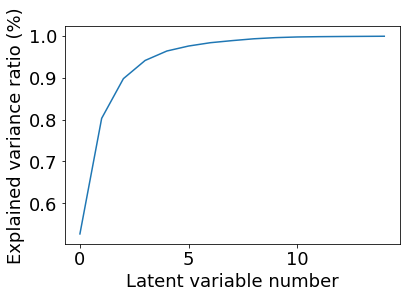

In [39]:
exp_variance_ratio_ = pipe1.named_steps['pca'].explained_variance_ratio_
cumsum=np.cumsum(exp_variance_ratio_)

plt.plot(range(cumsum.shape[0]), cumsum)
# Axis
#plt.plot([-40, 40], [0, 0], color='black', ls='--')
#plt.plot([0, 0], [-14, 14], color='black', ls='--')
# Title
#plt.title('Cumulative sum - explained variance ratio')
plt.xlabel('Latent variable number')
plt.ylabel('Explained variance ratio (%)')
plt.savefig('elnet - pca latent variable.png', bbox_inches = 'tight')
plt.show()

In [40]:
cumsum

array([0.52718209, 0.80286943, 0.89758621, 0.94100535, 0.96353354,
       0.97542086, 0.98332962, 0.98830642, 0.99268311, 0.99545247,
       0.99702555, 0.99774035, 0.9981409 , 0.99845521, 0.99875253])

## Truncated spectras

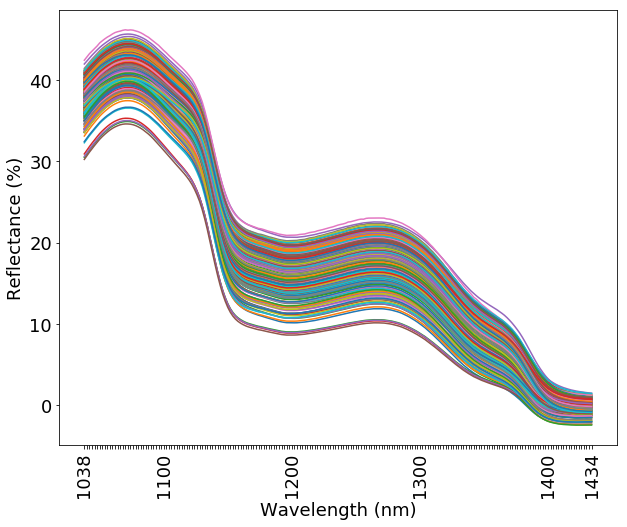

In [41]:
colnames = [str(x) for x in range(int(best['savgol__wavemin']), int(best['savgol__wavemax'])+1,2)]
df = spectra[colnames].T
df.plot(legend=False, figsize=(10,8))
#plt.title('Spectras')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.xticks(np.arange(len(colnames)), [v if (int(v) % 100 == 0) or k==0 or k==len(colnames)-1 else '' for (k,v) in enumerate(colnames)], rotation=90)
plt.savefig('elnet - Spectras - Elasticnet cleaning.png', bbox_inches = 'tight')
plt.show()

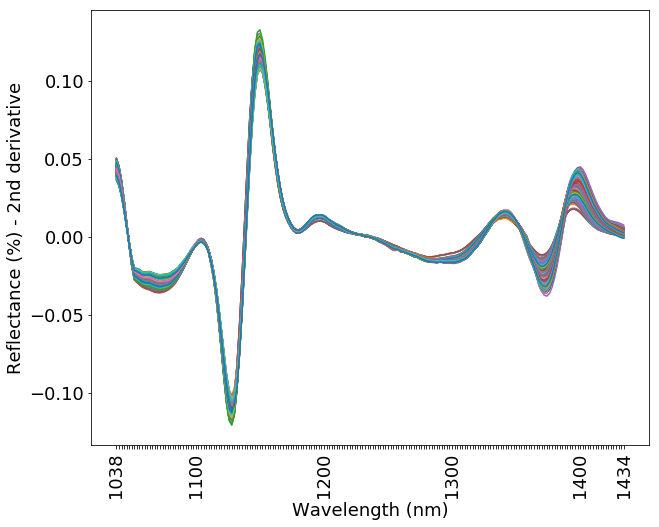

In [42]:
params={'window_length':int(best['savgol__window_length'])+1,
        'polyorder':int(best['savgol__polyorder']),
        'deriv':int(best['savgol__deriv']),
        'wavemin':int(best['savgol__wavemin']),
        'wavemax':int(best['savgol__wavemax'])}
savgol = Savgol(**params)

#colnames = [str(x) for x in range(int(best['savgol__wavemin']), int(best['savgol__wavemax'])+1,2)]
df = savgol.fit_transform(spectra).T
df.plot(legend=False, figsize=(10,8))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%) - {}nd derivative'.format(int(best['savgol__deriv'])))
plt.xticks(np.arange(len(colnames)), [v if (int(v) % 100 == 0) or k==0 or k==len(colnames)-1 else '' for (k,v) in enumerate(colnames)], rotation=90)
plt.savefig('elnet - Spectras-savgol - Elasticnet cleaning 2nd derivative.png', bbox_inches = 'tight')
plt.show()

In [43]:
preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf)
mean_squared_error(y_train, preds, )

20.40821893638054

# hyper parameters Sensitivity - RMSECV

In [44]:
alpha_range = np.logspace(-3, 0, 11)
l1_ratio_range = np.linspace(0.0001, 1, 11)
param_grid = dict(alpha=alpha_range, l1_ratio=l1_ratio_range)

elnet = ElasticNet(random_state=0, max_iter=10000)

gridrmse = GridSearchCV(elnet, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error') #'neg_mean_squared_error'
gridrmse.fit(Xtrans, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([0.001  , 0.002  , 0.00398, 0.00794, 0.01585, 0.03162, 0.0631 ,
       0.12589, 0.25119, 0.50119, 1.     ]), 'l1_ratio': array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
       5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
       1.0000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [45]:
gridrmse.best_params_

{'alpha': 0.003981071705534973, 'l1_ratio': 0.10009}

In [46]:
gridrmse.best_score_

-20.261486773062533

In [47]:
scores = gridrmse.cv_results_['mean_test_score'].reshape(len(l1_ratio_range),len(alpha_range))

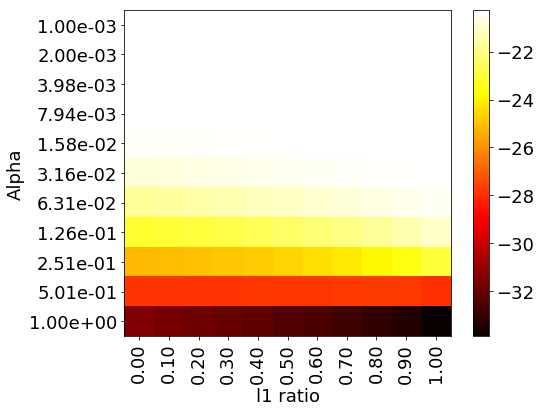

In [48]:
# heat map
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,)
plt.ylabel('Alpha')
plt.xlabel('l1 ratio')
cb = plt.colorbar()#.set_params(fontname="Times New Roman", fontsize=18)
plt.yticks(np.arange(len(alpha_range)), ['{:.2e}'.format(x) for x in alpha_range])
plt.xticks(np.arange(len(l1_ratio_range)), ['{:.2f}'.format(x) for x in l1_ratio_range], rotation=90)
#plt.yticks(fontname="Times New Roman", fontsize=18)
#plt.xticks(fontname="Times New Roman", fontsize=18)
plt.savefig('elnet - elasticnet sensitivity.png', bbox_inches = 'tight')
plt.show()

In [49]:
# RMSECV TRAIN SCORE
elnet = ElasticNet(random_state=0, max_iter=10000, **gridrmse.best_params_)
predsrmse = cross_val_predict(elnet, Xtrans, y_train, cv=kf)

(mean_squared_error(predsrmse, y_train))**.5

4.501276127173552

In [50]:
# RMSE TEST SCORE

#Fit with best parameters
Xtranstest = pipe1.transform(X_test)
elnet = ElasticNet(random_state=0, max_iter=10000, **gridrmse.best_params_)
elnet.fit(Xtrans, y_train)


# Prediction on test set
preds_test = elnet.predict(Xtranstest)
(mean_squared_error(preds_test, y_test))**.5

4.5404772694494

# hyper parameters Sensitivity - R2

In [51]:
alpha_range = np.logspace(-3, 0, 11)
l1_ratio_range = np.linspace(0.0001, 1, 11)
param_grid = dict(alpha=alpha_range, l1_ratio=l1_ratio_range)

elnet = ElasticNet(random_state=0)

gridr2 = GridSearchCV(elnet, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='r2') #'neg_mean_squared_error'
gridr2.fit(Xtrans, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([0.001  , 0.002  , 0.00398, 0.00794, 0.01585, 0.03162, 0.0631 ,
       0.12589, 0.25119, 0.50119, 1.     ]), 'l1_ratio': array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
       5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
       1.0000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [52]:
gridr2.best_params_

{'alpha': 0.003981071705534973, 'l1_ratio': 0.10009}

In [53]:
gridr2.best_score_

0.7406300567941614

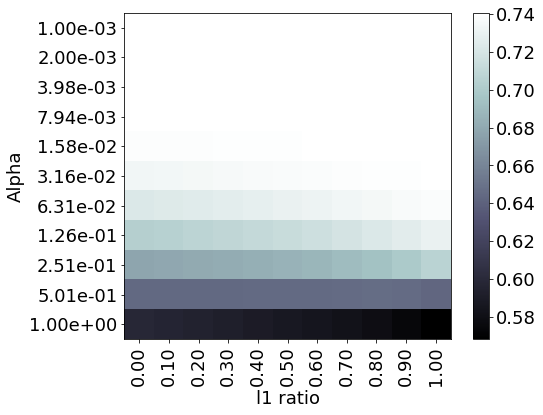

In [54]:
# heat map
scores = gridr2.cv_results_['mean_test_score'].reshape(len(l1_ratio_range),len(alpha_range))
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.bone,)
plt.ylabel('Alpha')
plt.xlabel('l1 ratio')
plt.colorbar()
plt.yticks(np.arange(len(alpha_range)), ['{:.2e}'.format(x) for x in alpha_range])
plt.xticks(np.arange(len(l1_ratio_range)), ['{:.2f}'.format(x) for x in l1_ratio_range], rotation=90)
plt.savefig('elnet - elasticnet sensitivity - R2.png', bbox_inches = 'tight')
plt.show()

In [55]:
# R2 CV train set

elnet = ElasticNet(random_state=0, max_iter=10000, **gridr2.best_params_)
predsr2 = cross_val_predict(elnet, Xtrans, y_train, cv=kf)
r2_score( y_train,predsr2 , )

0.7442047582044475

In [56]:
# R2 CV test set

elnet = ElasticNet(random_state=0, max_iter=10000, **gridr2.best_params_)
#Fit with best parameters

Xtranstest = pipe1.transform(X_test)
elnet.fit(Xtrans, y_train)

predsr2 = elnet.predict(Xtranstest)
r2_score( y_test,predsr2 )

0.7159434182475284

In [57]:
bestscores[bestindex][2]

{'alpha': 0.05008987210036727,
 'l1_ratio': 0.9461563866326491,
 'savgol__deriv': 2.0,
 'savgol__polyorder': 3.0,
 'savgol__wavemax': 1424.0,
 'savgol__wavemin': 1040.0,
 'savgol__window_length': 18.0}

## Score accuracy - Elastic Net

In [58]:
elnet

ElasticNet(alpha=0.003981071705534973, copy_X=True, fit_intercept=True,
      l1_ratio=0.10009, max_iter=10000, normalize=False, positive=False,
      precompute=False, random_state=0, selection='cyclic', tol=0.0001,
      warm_start=False)

In [59]:
# Generate test results

elnet = ElasticNet(alpha=bestscores[bestindex][2]['alpha'], l1_ratio=bestscores[bestindex][2]['l1_ratio'])

#Fit with best parameters
Xtrans = pipe1.fit_transform(X_train)
elnet.fit(Xtrans, y_train)
preds_train = elnet.predict(Xtrans)

# Prediction on test set
Xtranstest = pipe1.transform(X_test)
preds_test = elnet.predict(Xtranstest)
(mean_squared_error(y_test, preds_test, ))**.5

4.561625021636982

In [60]:
df = pd.DataFrame({'target':y_test, 'pred':preds_test}) #
df.head()

,target,pred
562,86.333333,86.340373
525,90.333333,87.342827
243,91.000000,94.786928
8,94.666667,90.922148
123,75.666667,72.542768


In [61]:
df['delta'] = df['target'] - df['pred']
df['deltaabs'] = np.abs(df['delta'])
df.head()

,target,pred,delta,deltaabs
562,86.333333,86.340373,-0.007040,0.007040
525,90.333333,87.342827,2.990506,2.990506
243,91.000000,94.786928,-3.786928,3.786928
8,94.666667,90.922148,3.744519,3.744519
123,75.666667,72.542768,3.123899,3.123899


In [62]:
df[['delta']].describe()

,delta
count,196.000000
mean,-0.245159
std,4.566697
min,-12.606300
25%,-3.392502
50%,-0.159812
75%,2.735126
max,13.345804


In [63]:
import seaborn as sns

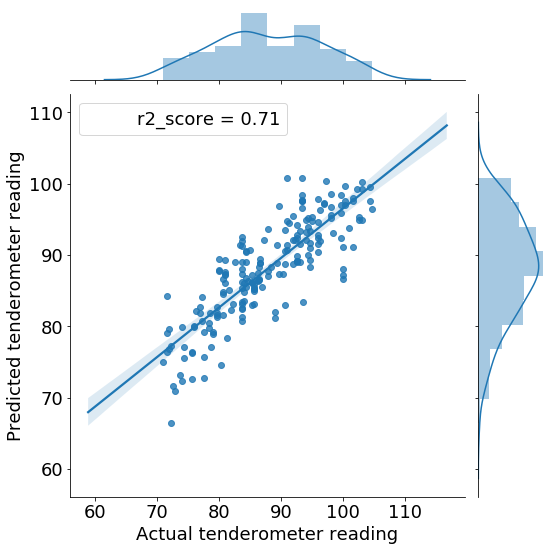

In [64]:
from scipy import stats
from sklearn.metrics import r2_score

sns.jointplot(x='target', y='pred', data=df,  height=8, stat_func=r2_score, kind='reg')
plt.xlabel('Actual tenderometer reading')
plt.ylabel('Predicted tenderometer reading')

plt.savefig('elnet - result regression.png', bbox_inches = 'tight')
plt.show()

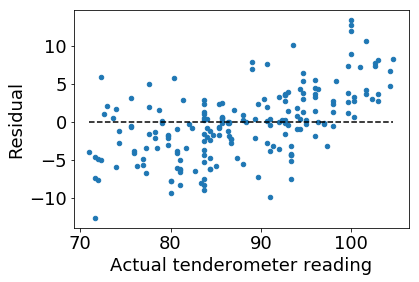

,delta
count,196.000000
mean,-0.245159
std,4.566697
min,-12.606300
25%,-3.392502
50%,-0.159812
75%,2.735126
max,13.345804


In [65]:

df.plot.scatter('target', 'delta')
plt.plot([df['target'].min(), df['target'].max()], [0, 0], color='k', linestyle='--')
#plt.title('Delta error ')
plt.xlabel('Actual tenderometer reading')
plt.ylabel('Residual')



plt.savefig('elnet - residual.png', bbox_inches = 'tight')
plt.show()
df[['delta']].describe()

# Result saving

In [66]:
params = bestscores[bestindex][2]
params = {**params, 'alpha' : elnet.alpha, 'l1_ratio' : elnet.l1_ratio}
params = {**params, 'RMSE train':mean_squared_error(y_train, preds_train)**.5, 'R2 train':r2_score(y_train, preds_train)}
params = {**params, 'RMSE test':mean_squared_error(y_test, preds_test)**.5, 'R2 test':r2_score(y_test, preds_test)}
params

{'alpha': 0.05008987210036727,
 'l1_ratio': 0.9461563866326491,
 'savgol__deriv': 2.0,
 'savgol__polyorder': 3.0,
 'savgol__wavemax': 1424.0,
 'savgol__wavemin': 1040.0,
 'savgol__window_length': 18.0,
 'RMSE train': 4.338399355743734,
 'R2 train': 0.7623815245697347,
 'RMSE test': 4.561625021636982,
 'R2 test': 0.71329120909525}

In [67]:
samplesize = df.shape[0]
print('sample size:', samplesize)

for errorabs in [1 ,2 ,3 ,4 ,6 ,8, 10]:
    correctcount = df[df['deltaabs'] < errorabs].shape[0]
    percent = correctcount/samplesize
    print('prediction +/- {:.1f} : percent {:05.02f} %'.format(errorabs, percent*100))
    params = {**params, 'preds +/-{}'.format(int(errorabs)):percent}


sample size: 196
prediction +/- 1.0 : percent 23.47 %
prediction +/- 2.0 : percent 37.24 %
prediction +/- 3.0 : percent 50.51 %
prediction +/- 4.0 : percent 64.29 %
prediction +/- 6.0 : percent 80.10 %
prediction +/- 8.0 : percent 92.35 %
prediction +/- 10.0 : percent 96.94 %


In [68]:
resultset = pd.DataFrame(params, index=['elnet'])
resultset.to_csv('../data/res_elnet.csv')
resultset.T

,elnet
alpha,0.050090
l1_ratio,0.946156
savgol__deriv,2.000000
savgol__polyorder,3.000000
savgol__wavemax,1424.000000
savgol__wavemin,1040.000000
savgol__window_length,18.000000
RMSE train,4.338399
R2 train,0.762382
RMSE test,4.561625
